<a href="https://www.kaggle.com/code/utkarshx27/multi-label-classification?scriptVersionId=135418929" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor as cbr
import lightgbm as lgb
from lightgbm import LGBMRegressor as lgbmr
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e18/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e18/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e18/sample_submission.csv')

# Statistical Summary

In [3]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['missing'] = df.isnull().sum().values
    summ['missing[%]'] = df.isnull().sum().values / len(df) * 100
    summ['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['median'] = df.median().values
    summ['std'] = df.std().values

    numeric_columns = df.select_dtypes(include=np.number).columns
    for col in numeric_columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        summ.loc[col, 'outliers'] = outliers.count()
        summ.loc[col, 'lower_bound'] = lower_bound
        summ.loc[col, 'upper_bound'] = upper_bound

    return summ

summary(train)

data shape: (14838, 38)


,data type,missing,missing[%],unique,min,max,median,std,outliers,lower_bound,upper_bound
id,int64,0,0.0,14838,0.000000,14837.000000,7418.500000,4283.505982,0.0,-7418.500000,22255.500000
BertzCT,float64,0,0.0,2368,0.000000,4069.959780,290.987941,542.456370,1301.0,-606.219875,1407.976061
Chi1,float64,0,0.0,1259,0.000000,69.551167,6.485270,6.819989,1175.0,-5.053867,20.905083
Chi1n,float64,0,0.0,3157,0.000000,50.174588,4.052701,4.647064,1178.0,-4.118796,14.450143
Chi1v,float64,0,0.0,3306,0.000000,53.431954,4.392859,5.866444,1158.0,-5.459684,16.920385
Chi2n,float64,0,0.0,3634,0.000000,32.195368,2.970427,3.760516,1190.0,-3.808893,11.547405
Chi2v,float64,0,0.0,3725,0.000000,34.579313,3.242775,4.925065,1194.0,-4.827854,13.471673
Chi3v,float64,0,0.0,3448,0.000000,22.880836,1.948613,3.436208,1180.0,-3.851197,9.514030
Chi4n,float64,0,0.0,2930,0.000000,16.072810,1.073261,1.865898,697.0,-2.541680,5.579858
EState_VSA1,float64,0,0.0,719,0.000000,363.705954,17.353601,31.728679,198.0,-52.391576,103.237440


# Numerical Distribution

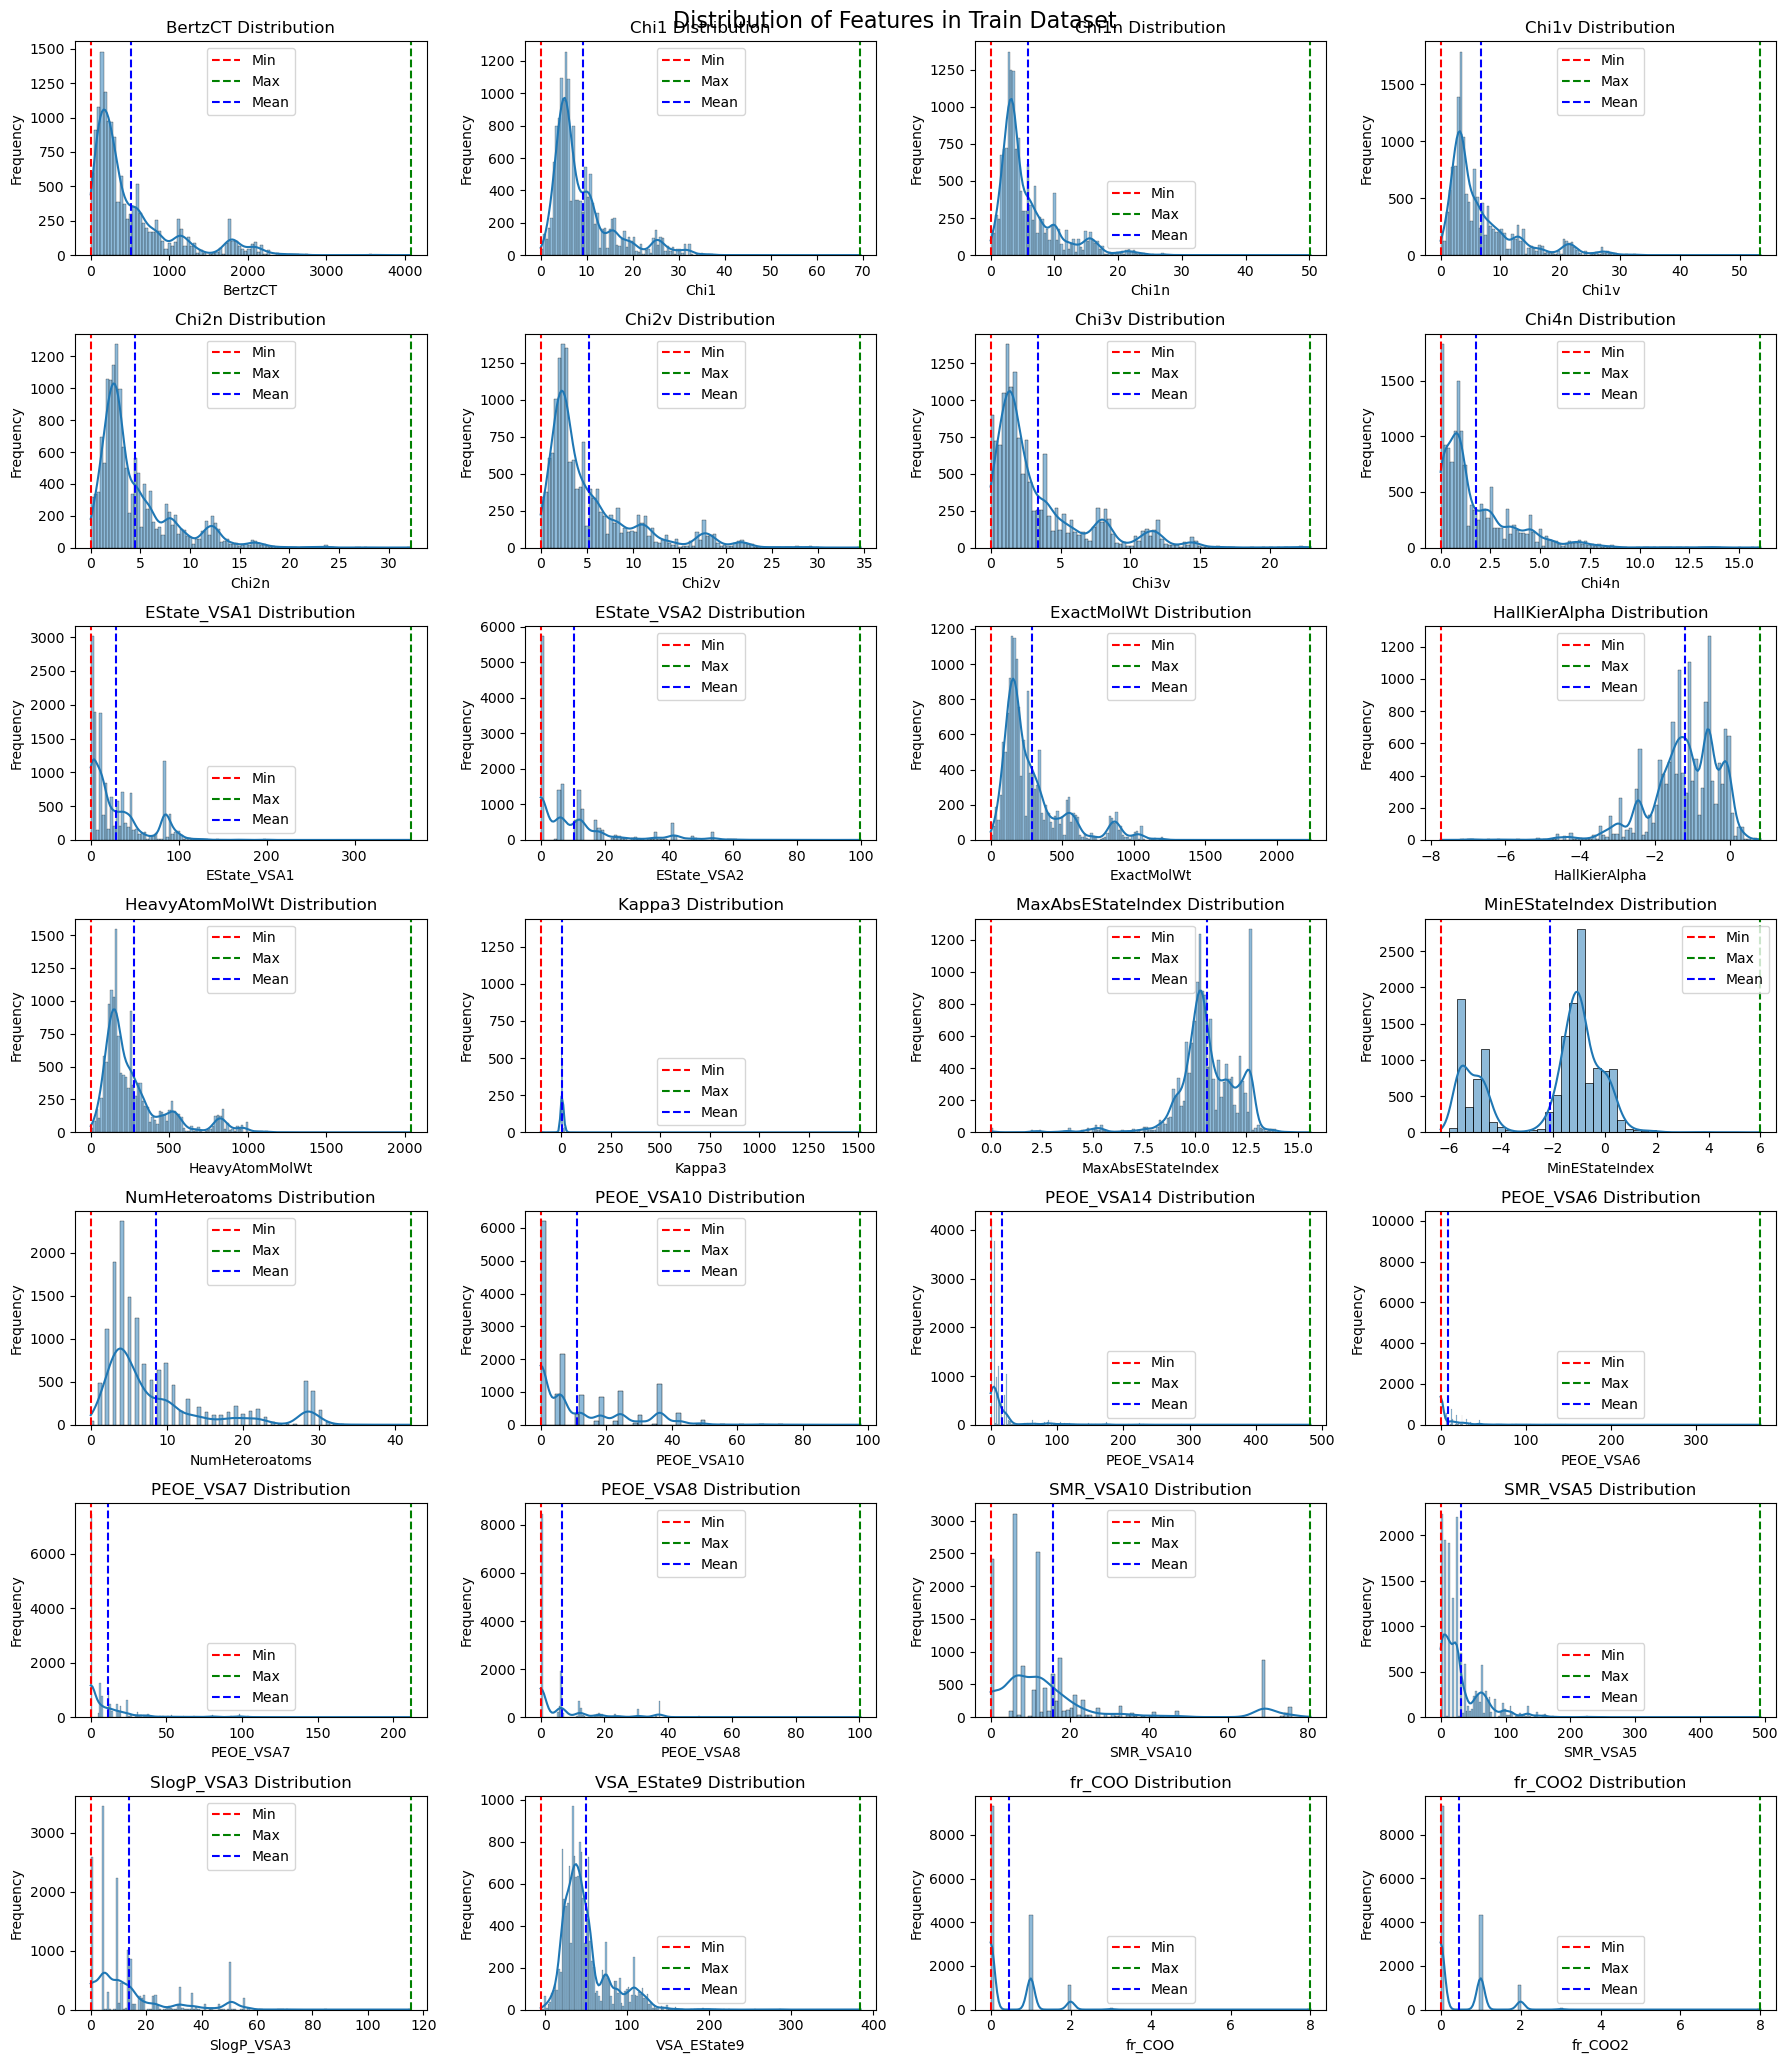

In [4]:
columns_n = ['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v',
            'Chi4n', 'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'HallKierAlpha',
            'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
            'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
            'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
            'fr_COO', 'fr_COO2']

num_cols = len(columns_n)
num_rows = math.ceil(num_cols / 4)

fig, axes = plt.subplots(num_rows, 4, figsize=(18, num_rows * 3))
fig.suptitle('Distribution of Features in Train Dataset', fontsize=16)

for i, column in enumerate(columns_n):
    row = i // 4
    col = i % 4
    ax = axes[row, col] if num_rows > 1 else axes[col]

    sns.histplot(data=train, x=column, kde=True, ax=ax)
    ax.set_title(f'{column} Distribution', fontsize=12)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

    min_value = train[column].min()
    max_value = train[column].max()
    mean_value = train[column].mean()
    ax.axvline(min_value, color='r', linestyle='--', label='Min')
    ax.axvline(max_value, color='g', linestyle='--', label='Max')
    ax.axvline(mean_value, color='b', linestyle='--', label='Mean')
    ax.legend()

fig.tight_layout()
plt.show()

# Cross-tabulation between the EC1 and EC2 

In [5]:
ec_classes = train[['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6']]
cross_tab = pd.crosstab(ec_classes['EC1'], ec_classes['EC2'])
print(cross_tab)

EC2     0     1
EC1            
0     582  4348
1    2401  7507


# Correlation Matrix of EC Classes

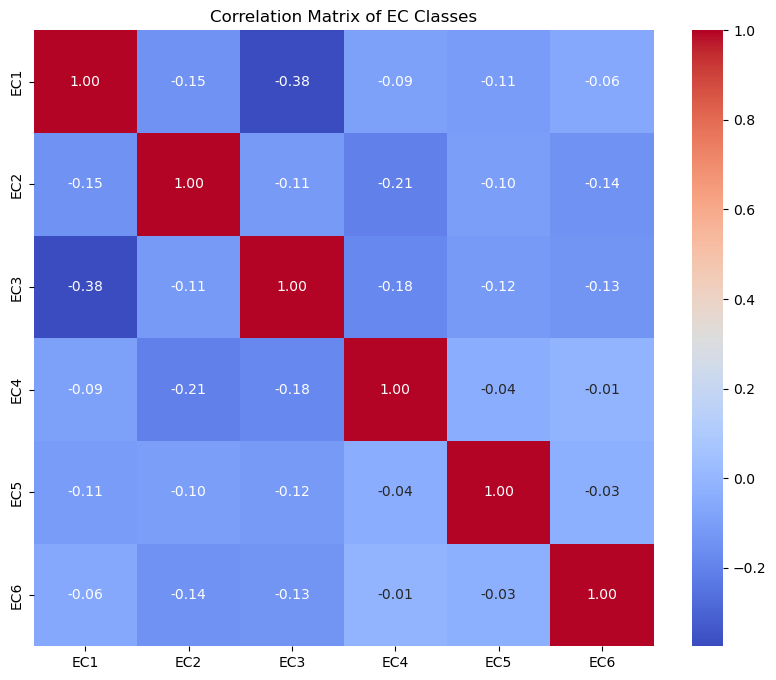

In [6]:
correlation_matrix = ec_classes.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix of EC Classes')
plt.show()

In [7]:
X = train.drop(['EC1', 'EC2'], axis=1)  
y_ec1 = train['EC1'] 
y_ec2 = train['EC2']  

rf = RandomForestRegressor(random_state=42)

rf.fit(X, y_ec1)
feature_importances_ec1 = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances_ec1 = feature_importances_ec1.sort_values('Importance', ascending=False)

print("Top 10 features for EC1:")
print(feature_importances_ec1.head(10))

rf.fit(X, y_ec2)
feature_importances_ec2 = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances_ec2 = feature_importances_ec2.sort_values('Importance', ascending=False)

print("Top 10 features for EC2:")
print(feature_importances_ec2.head(10))

Top 10 features for EC1:
              Feature  Importance
32                EC3    0.141600
20     NumHeteroatoms    0.061229
0                  id    0.045517
34                EC5    0.038447
33                EC4    0.037551
19     MinEStateIndex    0.037463
18  MaxAbsEStateIndex    0.035808
35                EC6    0.033125
17             Kappa3    0.032508
29        VSA_EState9    0.030152
Top 10 features for EC2:
              Feature  Importance
0                  id    0.059660
19     MinEStateIndex    0.048032
33                EC4    0.043125
17             Kappa3    0.042143
18  MaxAbsEStateIndex    0.041368
15      HallKierAlpha    0.038580
1             BertzCT    0.038090
29        VSA_EState9    0.037436
12   FpDensityMorgan1    0.037225
14   FpDensityMorgan3    0.037154


# PCA: Dimensionality Reduction

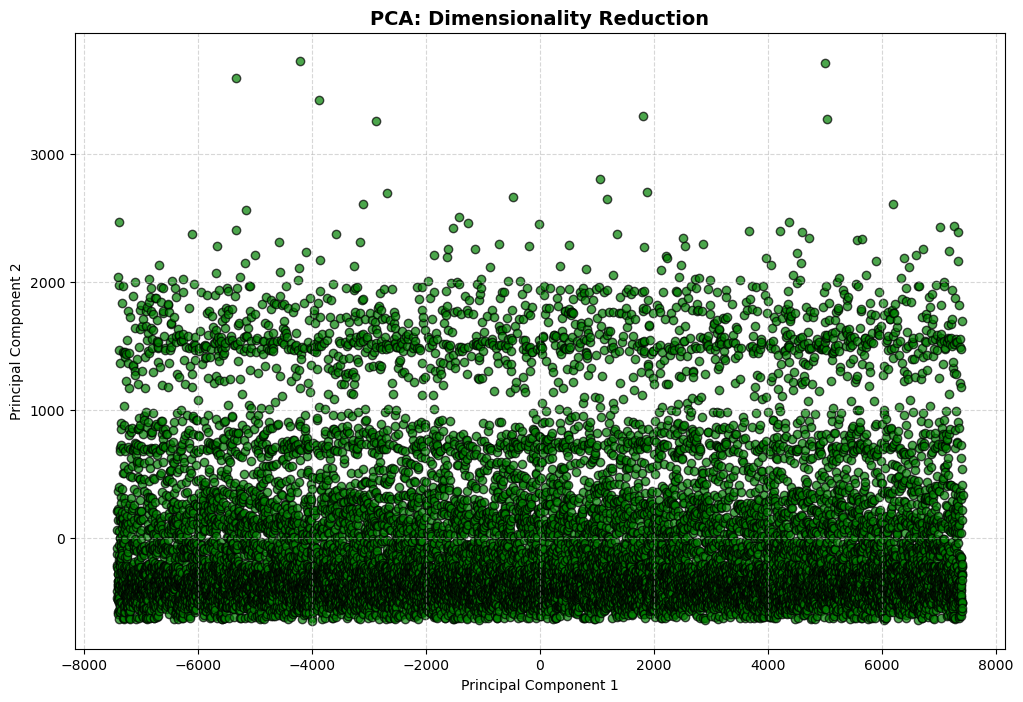

In [8]:
features = train.drop(['EC1', 'EC2'], axis=1)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

plt.figure(figsize=[12, 8])
plt.scatter(pca_result[:, 0], pca_result[:, 1], color='green', alpha=0.7, edgecolor='black')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Dimensionality Reduction', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Target Columns Distribution

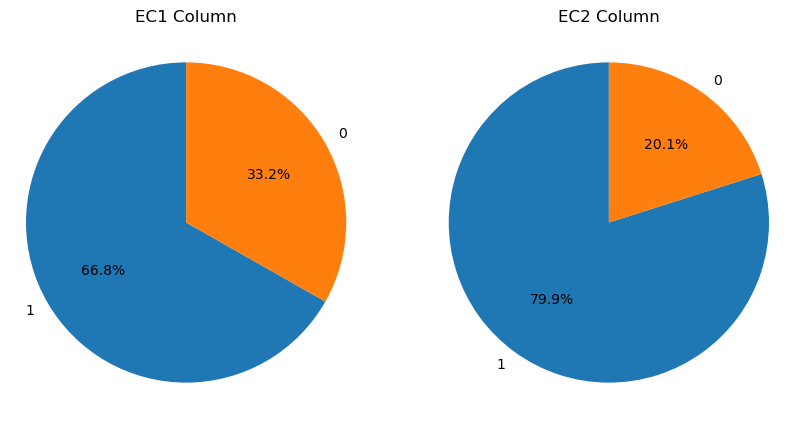

In [9]:
ec1_counts = train['EC1'].value_counts()

data1 = ec1_counts.values
labels1 = ec1_counts.index

ec2_counts = train['EC2'].value_counts()

data2 = ec2_counts.values
labels2 = ec2_counts.index

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].pie(data1, labels=labels1, autopct='%1.1f%%', startangle=90)
axes[0].axis('equal')
axes[0].set_title('EC1 Column')

axes[1].pie(data2, labels=labels2, autopct='%1.1f%%', startangle=90)
axes[1].axis('equal')
axes[1].set_title('EC2 Column')
plt.show()

# Feature Enginnering

In [10]:
# train['ExactMolWt_to_HeavyAtomMolWt'] = train['ExactMolWt'] / train['HeavyAtomMolWt']
# train['BertzCT_squared'] = train['BertzCT'] ** 2

# fp_density_cols = ['FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3']
# train['FpDensityMorgan_mean'] = train[fp_density_cols].mean(axis=1)
# train['FpDensityMorgan_std'] = train[fp_density_cols].std(axis=1)

# train['Chi1_times_EState_VSA1'] = train['Chi1'] * train['EState_VSA1']
# train['ExactMolWt_divided_by_Chi2n'] = train['ExactMolWt'] / train['Chi2n']

# train['fr_COO_ratio'] = train['fr_COO'] / train['fr_COO2']
# train['fr_COO_minus_fr_COO2'] = train['fr_COO'] - train['fr_COO2']



# pca = PCA(n_components=2)
# pca_features = pca.fit_transform(train[['BertzCT', 'ExactMolWt', 'Chi1']])
# train['PCA_1'] = pca_features[:, 0]
# train['PCA_2'] = pca_features[:, 1]

# print(train.head())

# Data Preprocessing

In [11]:
test.drop('id', axis = 1, inplace= True)
features = ['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v',
       'Chi4n', 'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
       'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'fr_COO2']

target = ['EC1', 'EC2']

In [12]:
scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])
train.shape, test.shape

X = train[features]
y = train[target]

y_EC1 = y['EC1']
y_EC2 = y['EC2']

X_train, X_test, y_EC1_train, y_EC1_test, y_EC2_train, y_EC2_test = train_test_split(X, y_EC1, y_EC2, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_EC1_train.shape, y_EC1_test.shape, y_EC2_train.shape, y_EC2_test.shape

((10386, 31), (4452, 31), (10386,), (4452,), (10386,), (4452,))

# LGBM Regressor

In [13]:
model_EC1 = lgb.LGBMRegressor(n_estimators=1000, objective='binary')
model_EC1.fit(X_train, y_EC1_train)

y_EC1_pred = model_EC1.predict(X_test)

roc_auc_EC1 = roc_auc_score(y_EC1_test, y_EC1_pred)
print("ROC AUC Score:", roc_auc_EC1)

model_EC2 = lgb.LGBMRegressor(n_estimators=1000, objective='binary')
model_EC2.fit(X_train, y_EC2_train)

y_EC2_pred = model_EC2.predict(X_test)

roc_auc_EC2 = roc_auc_score(y_EC2_test, y_EC2_pred)
print("ROC AUC Score:", roc_auc_EC2)

ROC AUC Score: 0.6685616343876475
ROC AUC Score: 0.5348139866481016


# Simple Neural Network

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=len(features)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_scaled, y_EC1_train, epochs=10, batch_size=32, verbose=1)

loss, accuracy = model.evaluate(X_test_scaled, y_EC1_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

y_pred_prob = model.predict(X_test_scaled)
auc_score = roc_auc_score(y_EC1_test, y_pred_prob)
print("AUC Score:", auc_score)

Epoch 1/10
325/325 [==============================] - 1s 1ms/step - loss: 0.6003 - accuracy: 0.6820
Epoch 2/10
325/325 [==============================] - 0s 1ms/step - loss: 0.5787 - accuracy: 0.7023
Epoch 3/10
325/325 [==============================] - 0s 1ms/step - loss: 0.5744 - accuracy: 0.7072
Epoch 4/10
325/325 [==============================] - 0s 1ms/step - loss: 0.5722 - accuracy: 0.7078
Epoch 5/10
325/325 [==============================] - 0s 1ms/step - loss: 0.5709 - accuracy: 0.7103
Epoch 6/10
325/325 [==============================] - 0s 1ms/step - loss: 0.5688 - accuracy: 0.7102
Epoch 7/10
325/325 [==============================] - 0s 1ms/step - loss: 0.5674 - accuracy: 0.7112
Epoch 8/10
325/325 [==============================] - 0s 1ms/step - loss: 0.5659 - accuracy: 0.7117
Epoch 9/10
325/325 [==============================] - 0s 1ms/step - loss: 0.5643 - accuracy: 0.7179
Epoch 10/10
140/140 [==============================] - 0s 921us/step - loss: 0.5841 - accuracy: 0.70

In [15]:
# test_scaled = scaler.transform(test[features])
# ec1 = model.predict(test_scaled).reshape(-1) 
# ec2 = model_EC2.predict(test_scaled).reshape(-1)
# ids = pd.read_csv('/kaggle/input/playground-series-s3e18/test.csv')['id']
# submission = pd.DataFrame({
#     'id': ids,
#     'EC1': ec1,
#     'EC2': ec2
# })
# submission.to_csv('submission4.csv', index=False)

In [16]:
# ec1 = model_EC1.predict(test)
# ec2 = model_EC2.predict(test)
# ids = pd.read_csv('/kaggle/input/playground-series-s3e18/test.csv')['id']

# submission = pd.DataFrame({
#     'id': ids,
#     'EC1': ec1,
#     'EC2': ec2
# })
# submission.to_csv('submission3.csv', index=False)